In [1]:
import yfinance as yf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

plt.style.use('fivethirtyeight')

In [2]:
tickers = ['IBM', 'GOOG', 'AMZN', ]

In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days=365*2)
start_date

datetime.datetime(2021, 11, 20, 15, 0, 45, 556242)

In [4]:
close_df = pd.DataFrame()

In [5]:
for ticker in tickers:
    data= yf.download(ticker, start=start_date, end=end_date)
    close_df[ticker] = data['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
close_df.head()

,IBM,GOOG,AMZN
Date,,,
2021-11-22,116.470001,147.078506,178.628494
2021-11-23,116.790001,146.757004,179.001999
2021-11-24,116.730003,146.717499,179.020493
2021-11-26,115.809998,142.806000,175.227997
2021-11-29,118.500000,146.113998,178.078506


In [7]:
returns = close_df.pct_change()
returns.head()

,IBM,GOOG,AMZN
Date,,,
2021-11-22,NaN,NaN,NaN
2021-11-23,0.002747,-0.002186,0.002091
2021-11-24,-0.000514,-0.000269,0.000103
2021-11-26,-0.007881,-0.026660,-0.021185
2021-11-29,0.023228,0.023164,0.016267


In [8]:
means = returns.mean()
means

IBM     0.000630
GOOG    0.000100
AMZN   -0.000054
dtype: float64

In [9]:
variances = returns.var()
variances

IBM     0.000171
GOOG    0.000485
AMZN    0.000724
dtype: float64

In [10]:
cov_matrix = returns.cov()
cov_matrix

,IBM,GOOG,AMZN
IBM,0.000171,0.000086,0.000091
GOOG,0.000086,0.000485,0.000409
AMZN,0.000091,0.000409,0.000724


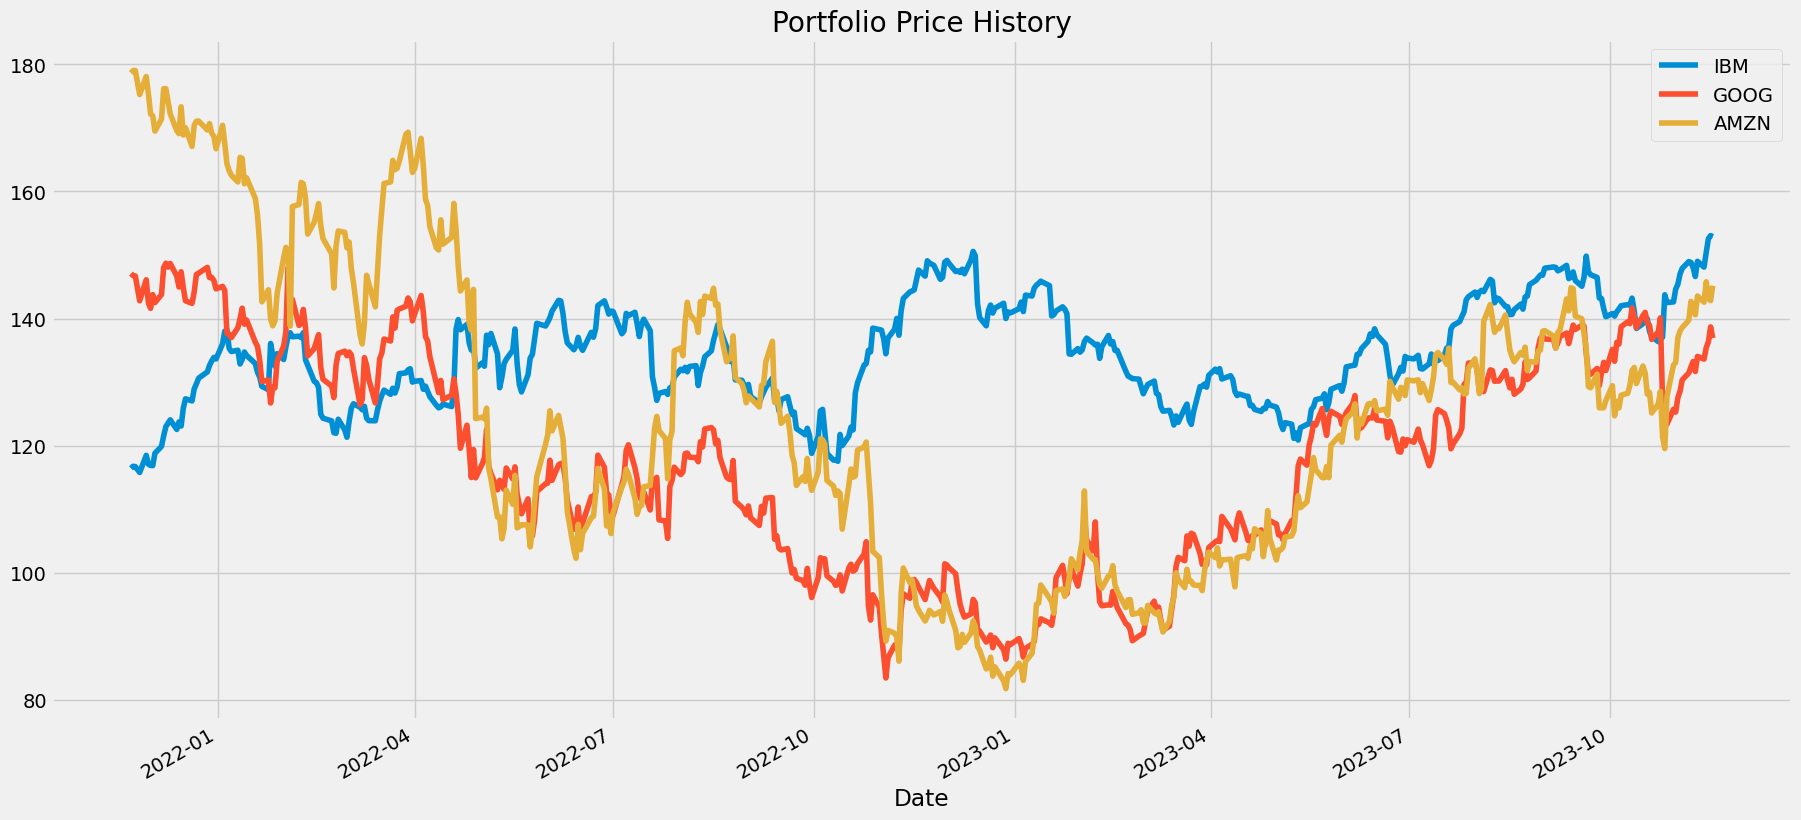

In [11]:
title = 'Portfolio Price History'
stocks = close_df
stocks.plot(title=title, figsize=(20,10))
plt.show()

In [12]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = means
S = cov_matrix
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))

# ef.efficient_return(target_return=0.001, market_neutral=True)
ef.min_volatility()

OrderedDict([('IBM', 0.8191664420759354),
             ('GOOG', 0.1561170573706486),
             ('AMZN', 0.024716500553416)])

In [13]:
ef.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 1.2%
Sharpe Ratio: -1.56


(0.0005301178526262393, 0.012494083467303478, -1.558328163752521)

In [17]:
def random_weights(n):
    k = np.random.rand(n)
    return k / sum(k)

weights = random_weights(len(tickers))
weights

array([0.25563253, 0.35840773, 0.38595974])

In [24]:
weights.sum()

1.0

In [20]:
def portfolio_return(weights):
    return np.sum(means * weights)

def portfolio_volatility(weights):
    # use covariance matrix
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


In [22]:
portfolio_return(weights)*100, portfolio_volatility(weights)

(0.017603200373993606, 0.0181114338408064)

In [23]:
def portfolio_annual_return(weights):
    return portfolio_return(weights) * 252
portfolio_annual_return(weights)

0.04436006494246389

In [27]:
# print returns and volatility in a readable format in percent
def print_portfolio(weights):
    print("Expected annual return: {:.1f}%".format(portfolio_annual_return(weights) * 100))
    print('Annual volatility: {:.1f}%'.format(portfolio_volatility(weights) * 100))

print_portfolio(weights)

Expected annual return: 4.4%
Annual volatility: 1.8%


In [31]:
# efficient frontier
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = means
S = cov_matrix
ef_ = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef_.min_volatility()

OrderedDict([('IBM', 0.8191664420759354),
             ('GOOG', 0.1561170573706486),
             ('AMZN', 0.024716500553416)])

In [32]:
ef_.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 1.2%
Sharpe Ratio: -1.56


(0.0005301178526262393, 0.012494083467303478, -1.558328163752521)

In [33]:
ef__= EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef__.min_volatility()

OrderedDict([('IBM', 0.8191664420759354),
             ('GOOG', 0.1561170573706486),
             ('AMZN', 0.024716500553416)])

In [34]:
ef__.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 1.2%
Sharpe Ratio: -1.56


(0.0005301178526262393, 0.012494083467303478, -1.558328163752521)

In [35]:
ef__.clean_weights()

OrderedDict([('IBM', 0.81917), ('GOOG', 0.15612), ('AMZN', 0.02472)])

In [36]:
ef__.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 1.2%
Sharpe Ratio: -1.56


(0.0005301178526262393, 0.012494083467303478, -1.558328163752521)

In [41]:
ef___ = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef___.max_sharpe(risk_free_rate=0.0001)

OrderedDict([('IBM', 1.0), ('GOOG', 0.0), ('AMZN', 0.0)])

In [43]:
import cvxpy as cp

weightscp= cp.Variable(len(means))
weightscp

Variable((3,), var297)

In [44]:
objective = cp.Minimize(cp.quad_form(weightscp, cov_matrix.values))

In [45]:
constraints = [weightscp >= 0, weightscp <= 1, cp.sum(weightscp) == 1]

In [46]:
problem = cp.Problem(objective, constraints)

In [47]:
problem.solve()

0.0001561021216879461

In [48]:
weightscp.value

array([0.81916644, 0.15611706, 0.0247165 ])

In [56]:
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("API_KEY")

In [57]:
from fredapi import Fred
fred=Fred(api_key=api_key)
rate=fred.get_series_latest_release('GS10')/100
rf=rate.iloc[-1]
rf

0.048

In [58]:
sharpe_ratio = (portfolio_annual_return(weights) - rf) / portfolio_volatility(weights)
sharpe_ratio

-0.20097442806185056